In [1]:
import numpy as np
from scipy.integrate import odeint
import random
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from dynamics import *
from plotting import *
from computation import *
from networkParameters import *
import matplotlib.pyplot as plt
import random


[[50  3]]
[[50  3]]


In [2]:
# Initialise network
internal_weights = np.random.standard_normal(size=(N, N))
input_weights = np.random.normal(0, 1, size=(N,2))
output_weights = np.random.normal(0, 1, size=(N, 2)).transpose()
leaking_matrix = np.identity(N)*a_internal

# scale internal weights
eigenvalues = eigvals(internal_weights)
scaling_factor = max(abs(eigenvalues))
print(scaling_factor)
internal_weights *= desired_spectral_radius/scaling_factor


22.601561885406053


[[50  3]]
[[50  3]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


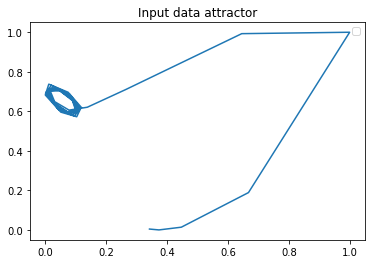

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


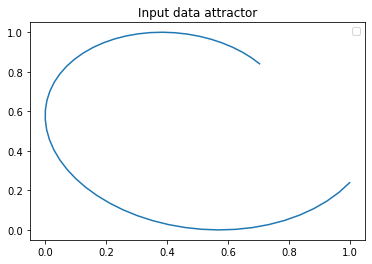

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


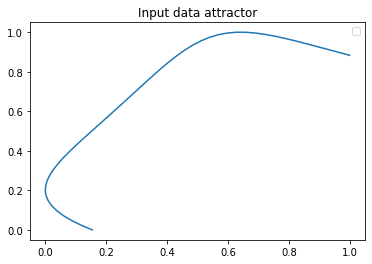

In [3]:
# collect training data for three different "strange" attractors
lorenz_input = generate_attractor_data()
rossler_input = generate_attractor_data([1, 1, 0], rossler, 0, 1)
mg_input = generate_mg_data()

plot_input_data_attractors(lorenz_input)
plot_input_data_attractors(rossler_input)
plot_input_data_attractors(mg_input)

0.0
1.2445284319134224e-05
1.2445284319134224e-05
2.4890568638268448e-05
2.4890568638268448e-05
0.011910952988203265
0.011910952988203265
0.02379701540776826
0.02379701540776826
0.03568307782733326
0.03568307782733326
0.08879616313617696
0.08879616313617696
0.07395827273454197
0.07395827273454197
0.1122334676417507
0.1122334676417507
0.1122334676417507
0.08620584909091697
0.08620584909091697
0.09845342544729196
0.09845342544729196
0.11070100180366696
0.11070100180366696
0.0990789656583591
0.0990789656583591
0.09970450586942622
0.09970450586942622
0.10033004608049335
0.10033004608049335
0.10158112650262761
0.10158112650262761
0.10283220692476187
0.10283220692476187
0.10283220692476187
0.10283220692476187
0.10183134258705447
0.10183134258705447
0.10208155867148132
0.10208155867148132
0.10184037376202841
0.10184037376202841
0.10184940493700236
0.10184940493700236
0.10186746728695024
0.10188552963689813
0.10190359198684602
0.10208421548632489
0.10208421548632489
0.10208421548632489
0.10208

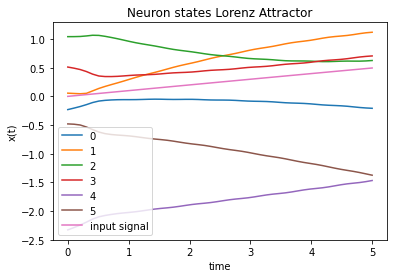

In [4]:
# drive system on lorenz attractor
parameters_training = (tau, leaking_matrix, internal_weights, input_weights, 0)
training_data_lorenz = odeint(leaky_esn_two_inputs, np.random.standard_normal(N), t, parameters_training)
plot_liquid_states(training_data_lorenz, title="Neuron states Lorenz Attractor")

0.0
1.2441641271812427e-05
1.2441641271812427e-05
2.4883282543624855e-05
2.4883282543624855e-05
0.010858378971958514
0.010858378971958514
0.0216918746613734
0.0216918746613734
0.032525370350788285
0.032525370350788285
0.06683758866873352
0.06683758866873352
0.06092246903448316
0.06092246903448316
0.08931956771817803
0.08931956771817803
0.11771666640187291
0.11771666640187291
0.10071805555631978
0.10071805555631978
0.11211654339446153
0.11211654339446153
0.10141105272586909
0.10141105272586909
0.1021040498954184
0.1021040498954184
0.10171512851331263
0.10171512851331263
0.10201920430075617
0.10201920430075617
0.10262735587564324
0.10262735587564324
0.10232332503093014
0.10232332503093014
0.10203167449415398
0.10203167449415398
0.1020441446875518
0.1020441446875518
0.10203420006700581
0.10203420006700581
0.10203672563985763
0.10203672563985763
0.10204177678556128
0.10204177678556128
0.10204177678556128
0.10204177678556128
0.10203773586899836
0.10203773586899836
0.1020387460981391
0.10203

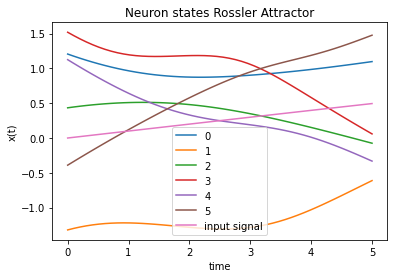

In [5]:
# drive system on rossler attractor
parameters_training = (tau, leaking_matrix, internal_weights, input_weights, 1)
training_data_rossler = odeint(leaky_esn_two_inputs, np.random.standard_normal(N), t, parameters_training)
plot_liquid_states(training_data_rossler, "Neuron states Rossler Attractor")

0.0
1.2440509018191281e-05
1.2440509018191281e-05
2.4881018036382563e-05
2.4881018036382563e-05
0.010357332161912524
0.010357332161912524
0.020689783305788665
0.020689783305788665
0.031022234449664808
0.031022234449664808
0.07182085034596837
0.07182085034596837
0.06237513888769947
0.06237513888769947
0.09372804332573414
0.09372804332573414
0.12508094776376882
0.12508094776376882
0.10484429491571975
0.10484429491571975
0.09485341803288301
0.09485341803288301
0.09597879274003188
0.09597879274003188
0.09710416744718074
0.09710416744718074
0.09935491686147847
0.09935491686147847
0.1016056662757762
0.1016056662757762
0.10385641569007394
0.10385641569007394
0.10385641569007394
0.10385641569007394
0.1019934844407183
0.1019934844407183
0.1023813026056604
0.1023813026056604
0.10234053668884949
0.10234053668884949
0.10202174658990262
0.10202174658990262
0.10205000873908694
0.10205000873908694
0.10202981291081058
0.10202981291081058
0.10203787923171853
0.10203787923171853
0.10205401187353443
0.10

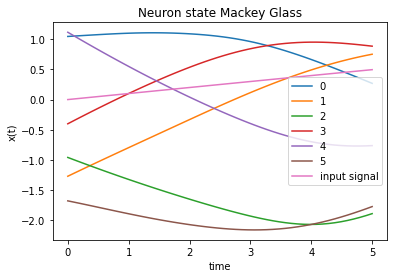

In [6]:
# drive system on Mackey-Glass attractor
parameters_training = (tau, leaking_matrix, internal_weights, input_weights, 2)
training_data_mg = odeint(leaky_esn_two_inputs, np.random.standard_normal(N), t, parameters_training)
plot_liquid_states(training_data_mg, title="Neuron state Mackey Glass")

In [8]:
print(training_data_lorenz.shape)
print(training_data_rossler.shape)
print(training_data_mg.shape)

# Compute and test readout weights
state_trajectories = [training_data_lorenz, training_data_rossler, training_data_mg]
input_matrices = [generate_pattern_matrix_from_dict(lorenz_input), generate_pattern_matrix_from_dict(rossler_input), generate_pattern_matrix_from_dict(mg_input)]
readout_weights = compute_output_weights(state_trajectories, input_matrices)
plt.plot(readout_weights)

(50, 500)
(50, 500)
(50, 500)


ValueError: shapes (500,120) and (6,50) not aligned: 120 (dim 1) != 6 (dim 0)

In [ ]:
# Perform loading procedure

In [ ]:
# Test retrieval